In [1]:
import torch
from train import prepare_cifar
from model import ResNet18
import os
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import copy
import pdb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
_, testloader = prepare_cifar()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cudnn.benchmark = True

net_set = []
for i in range(5):
    net_set.append(ResNet18())
    net_set[i] = net_set[i].to(device)
    net_set[i] = torch.nn.DataParallel(net_set[i])
    checkpoint = torch.load("./checkpoint/ckpt_{}.pth".format(i))
    net_set[i].load_state_dict(checkpoint["net"])
    print("{} {}".format(checkpoint["acc"], checkpoint["epoch"]))

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
94.39 88
94.38 89
94.54 79
94.29 87
94.37 75


In [5]:
def gen_dif(targets):
    targets = copy.deepcopy(targets.to("cpu").numpy())
    ret = []
    for tar in targets:
        rand_n = random.randint(0, 9)
        if rand_n == tar:
            rand_n = (rand_n + 1) % 10
        ret.append(rand_n)
    return torch.tensor(np.array(ret)).to(device)

In [15]:
def bad_case(net_set):
    pred_results = []
    gt = np.array([], dtype=np.int32)
    for i in range(5):
        net_set[i].eval()
        results = np.array([], dtype=np.int32)
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(testloader):
                if i == 0:
                    gt = np.concatenate((gt, targets), axis=0)
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net_set[i](inputs)
                _, pred = outputs.max(1)
                pred = copy.deepcopy(pred.to("cpu").numpy())
                results = np.concatenate((results, pred), axis=0)
                print(batch_idx)
        print(results.shape)
        pred_results.append(results)
    
    def iou(pred1, pred2, gt):
        inter_sz = 0
        union_sz = 0
        for i in range(pred1.shape[0]):
            if gt[i] != pred1[i] or gt[i] != pred2[i]:
                union_sz += 1
                if pred1[i] == pred2[i]:
                    inter_sz += 1
        return inter_sz / union_sz
    
    def iou2(pred1, pred2, gt):
        inter_sz = 0
        union_sz = 0
        for i in range(pred1.shape[0]):
            if gt[i] != pred1[i] or gt[i] != pred2[i]:
                union_sz += 1
                if gt[i] != pred1[i] and gt[i] != pred2[i]:
                    inter_sz += 1
        return inter_sz / union_sz
    
    for i in range(5):
        for j in range(i + 1, 5):
            print(iou(pred_results[i], pred_results[j], gt), iou2(pred_results[i], pred_results[j], gt))
bad_case(net_set)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
(10000,)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
(10000,)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
(10000,)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
(10000,)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


0.9377 0.9383 0.9344
0.905 0.9265 0.9039
0.7854 0.9018 0.8129
0.5197 0.8206 0.6266
0.2014 0.5573 0.5552
0.122 0.3122 0.7183
0.107 0.1464 0.8232


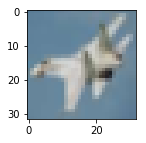

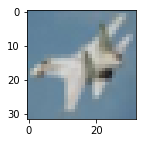

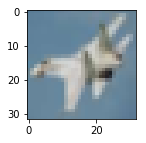

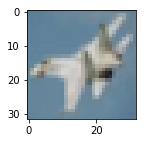

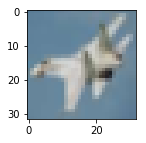

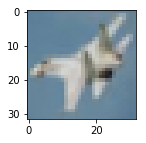

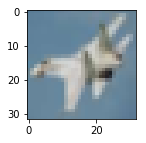

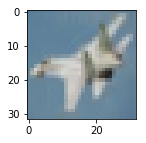

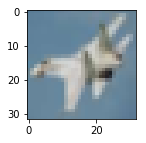

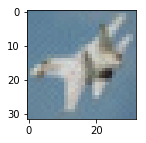

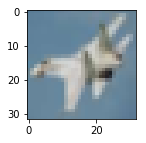

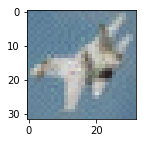

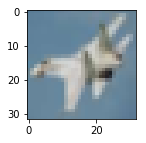

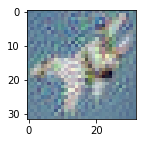

In [39]:
mean_channel = [0.4914, 0.4822, 0.4465]
std_channel = [0.2023, 0.1994, 0.2010]
def restore_fig(img):
    img = copy.deepcopy(img)
    for i in range(3):
        img[i, :, :] = 255 * (img[i, :, :] * std_channel[i] + mean_channel[i] + 1e-5)
    img = np.clip(img, 0, 255)
    
    img = img.astype(np.uint8)
    img = np.swapaxes(img, 0, 1)
    img = np.swapaxes(img, 1, 2)
    return img

def plot_img(img):
    #mport pdb
    #pdb.set_trace()
    plt.figure(figsize=(2, 2))
    plt.imshow(img)

def pertube(net, inps, targets, eps):
    length = 32. * 1.7
    iter_time = 5
    pert = torch.zeros(inps.shape, dtype=torch.float32).to(device)
    
    criterion = nn.CrossEntropyLoss()

    for i in range(iter_time):
        net.zero_grad()
        inputs = torch.autograd.Variable(inps - pert, requires_grad=True)
        outputs = net(inputs)
        #import pdb
        #pdb.set_trace()
        loss = criterion(outputs, targets)
        loss.backward()
        grad = inputs.grad.data
        grad = eps * length / 3 * grad / torch.norm(grad.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)
        pert = pert + grad
        pert = eps * length * pert / torch.norm(pert.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)
        pert = torch.clamp(pert, min=-1, max=1)
        
    return pert

    
def experiment_attack(net_set):
    for i in range(5):
        net_set[i].eval()
    for eps in [2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1, 3e-1]:
        for i in range(2):
            for j in range(i + 1, 2):
                acc1 = 0
                acc2 = 0
                acc3 = 0
                for batch_idx, (inputs, targets) in enumerate(testloader):
                    inps = inputs.to(device)
                    tgts = targets.to(device)
                    fake = torch.tensor(np.random.randint(0, 10, targets.shape[0]), dtype=torch.int64).to(device)
                    pert = pertube(net_set[i], inps, fake, eps)
                    inps -= pert
                    tmp = inps.to("cpu").numpy()
                    #import pdb
                    #pdb.set_trace()
                    if batch_idx == 0:
                        plot_img(restore_fig(inputs[10].numpy()))
                        plot_img(restore_fig(tmp[10]))

                    oup1 = net_set[i](inps)
                    oup2 = net_set[j](inps)
                    _, pred1 = oup1.max(1)
                    _, pred2 = oup2.max(1)
                    acc1 += pred1.eq(tgts).sum().item()
                    acc2 += pred2.eq(tgts).sum().item()
                    acc3 += pred2.eq(pred1).sum().item()
                
                acc1 /= 10000
                acc2 /= 10000
                acc3 /= 10000
                print(acc1, acc2, acc3)

                    
                
experiment_attack(net_set)

0.8653 0.9242 0.8715
0.6555 0.8914 0.7009
0.2212 0.7173 0.4195
0.118 0.4539 0.5626
0.1104 0.1862 0.8005


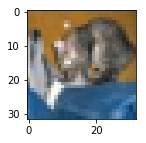

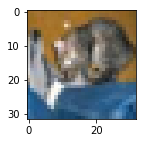

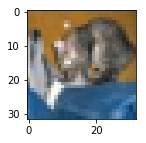

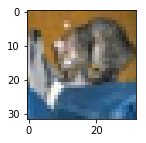

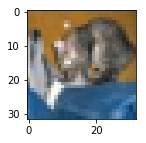

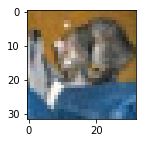

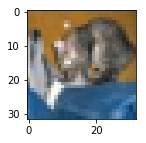

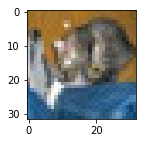

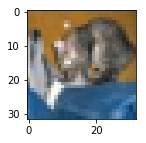

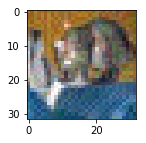

In [30]:
mean_channel = [0.4914, 0.4822, 0.4465]
std_channel = [0.2023, 0.1994, 0.2010]
def restore_fig(img):
    img = copy.deepcopy(img)
    for i in range(3):
        img[i, :, :] = 255 * (img[i, :, :] * std_channel[i] + mean_channel[i] + 1e-5)
    img = np.clip(img, 0, 255)
    
    img = img.astype(np.uint8)
    img = np.swapaxes(img, 0, 1)
    img = np.swapaxes(img, 1, 2)
    return img

def plot_img(img):
    #mport pdb
    #pdb.set_trace()
    plt.figure(figsize=(2, 2))
    plt.imshow(img)

def pertube(net, inps, targets, eps):
    length = 32. * 1.7
    eps2 = eps / 5 * 3
    iter_time = 10
    pert = torch.zeros(inps.shape, dtype=torch.float32).to(device)
    
    criterion = nn.CrossEntropyLoss()

    for i in range(iter_time):
        net.zero_grad()
        inputs = torch.autograd.Variable(inps - pert, requires_grad=True)
        outputs = net(inputs)
        #import pdb
        #pdb.set_trace()
        loss = criterion(outputs, targets)
        #print(loss)
        loss.backward()
        grad = torch.sign(inputs.grad.data) * eps2
        pert = torch.clamp(pert + grad, min=-eps, max=eps)
        #pert = eps * length * pert / torch.norm(pert.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)

    return pert

    
def experiment_attack2(net_set):
    for i in range(5):
        net_set[i].eval()
    for eps in [1e-2, 2e-2, 5e-2, 1e-1, 3e-1]:
        for i in range(2):
            for j in range(i + 1, 2):
                acc1 = 0
                acc2 = 0
                acc3 = 0
                for batch_idx, (inputs, targets) in enumerate(testloader):
                    inps = inputs.to(device)
                    tgts = targets.to(device)
                    fake = torch.tensor(np.random.randint(0, 10, targets.shape[0]), dtype=torch.int64).to(device)
                    pert = pertube(net_set[i], inps, fake, eps)
                    inps -= pert
                    tmp = inps.to("cpu").numpy()
                    #import pdb
                    #pdb.set_trace()
                    if batch_idx == 0:
                        plot_img(restore_fig(inputs[10].numpy()))
                        plot_img(restore_fig(tmp[10]))

                    oup1 = net_set[i](inps)
                    oup2 = net_set[j](inps)
                    _, pred1 = oup1.max(1)
                    _, pred2 = oup2.max(1)
                    acc1 += pred1.eq(tgts).sum().item()
                    acc2 += pred2.eq(tgts).sum().item()
                    acc3 += pred2.eq(pred1).sum().item()
                
                acc1 /= 10000
                acc2 /= 10000
                acc3 /= 10000
                print(acc1, acc2, acc3)

                    
                
experiment_attack2(net_set)

> <ipython-input-9-2ea88cad5976>(48)experiment_attack()
-> result1 = []
(Pdb) c
0
1
2
3
4
5
6
7
8
0.5982905982905983


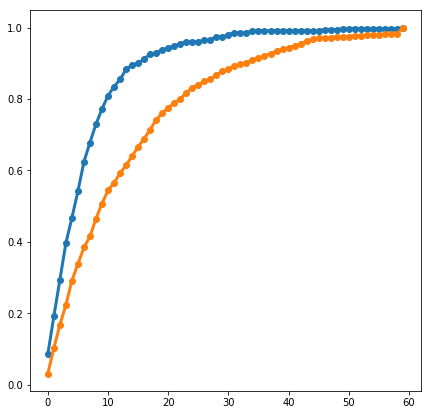

In [9]:
mean_channel = [0.4914, 0.4822, 0.4465]
std_channel = [0.2023, 0.1994, 0.2010]
def restore_fig(img):
    img = copy.deepcopy(img)
    for i in range(3):
        img[i, :, :] = 255 * (img[i, :, :] * std_channel[i] + mean_channel[i] + 1e-5)
    img = np.clip(img, 0, 255)
    
    img = img.astype(np.uint8)
    img = np.swapaxes(img, 0, 1)
    img = np.swapaxes(img, 1, 2)
    return img

def plot_img(img):
    #mport pdb
    #pdb.set_trace()
    plt.figure(figsize=(2, 2))
    plt.imshow(img)

import random
eps = [5e-4]
power = 1.05
powers = [1]
while eps[-1] <= 0.3:
    eps.append(eps[-1] * power)
    powers.append(powers[-1]*power)


def experiment_attack(net_set):
    for i in range(5):
        net_set[i].eval()
    
    for i in range(2):
        for j in range(i + 1, 2):
            ratio = []
            acc = 0
            for batch_idx, (inputs, targets) in enumerate(testloader):
                inputs = inputs.to(device)
                targets = targets.to(device)
                pert = torch.randn(inputs.shape).to(device)
                pert = pert / torch.norm(pert.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)
                
                if batch_idx == 0:
                    inps = copy.deepcopy((inputs + pert * 1 * 32 * 1.7)[10].to("cpu").numpy())
                    pdb.set_trace()
                    #plot_img(restore_fig(inps))
                
                result1 = []
                result2 = []
                predict1 = []
                predict2 = []
                for eps_i in range(len(eps)):
                    inps = inputs + pert * eps[eps_i] * 32. * 1.7
                    tmp = inps.to("cpu").numpy()

                    oup1 = net_set[i](inps)
                    oup2 = net_set[j](inps)
                    _, pred1 = oup1.max(1)
                    _, pred2 = oup2.max(1)
                    res1 = copy.deepcopy(pred1.eq(targets).to("cpu").numpy())
                    res2 = copy.deepcopy(pred2.eq(targets).to("cpu").numpy())
                    result1.append(res1)
                    result2.append(res2)
                    predict1.append(copy.deepcopy(pred1.to("cpu").numpy()))
                    predict2.append(copy.deepcopy(pred2.to("cpu").numpy()))
                
                result1 = np.array(result1)
                result2 = np.array(result2)
                predict1 = np.array(predict1)
                predict2 = np.array(predict2)
                #pdb.set_trace()
                for sample in range(targets.shape[0]):
                    first_i = 0
                    first_j = 0
                    for eps_i in range(len(eps)):
                        if result1[eps_i][sample] == 0 and not first_i:
                            first_i = eps_i + 1
                        if result2[eps_i][sample] == 0 and not first_j:
                            first_j = eps_i + 1
                    if not first_i:
                        first_i = len(eps)
                    if not first_j:
                        first_j = len(eps)
                    if first_i > first_j:
                        first_i2, first_j2 = first_j, first_i
                    else:
                        first_i2, first_j2 = first_i, first_j
                    
                    if first_i2 > 1 and first_j2 < len(eps):
                        #pdb.set_trace()
                        ratio.append([eps[first_j2 - 1] / eps[first_i2 - 1], first_i2, first_j2])
                        acc += predict1[first_i - 1][sample] == predict2[first_j - 1][sample]
                print(batch_idx)
                if batch_idx >= 8:
                    break
            #pdb.set_trace()
            print(acc / len(ratio))
            return ratio
        
ratio = experiment_attack(net_set)
#ratio = [[1.2155062500000002, 119, 123], [1.4774554437890632, 122, 130], [1.4774554437890632, 124, 132], [1.1025, 118, 120], [1.2155062500000005, 125, 129], [1.05, 125, 126], [2.078928179411368, 107, 122], [1.2155062500000002, 118, 122], [1.05, 124, 125], [1.0, 129, 129], [1.0, 130, 130], [1.2762815625000001, 118, 123], [1.05, 130, 131], [1.1576250000000003, 128, 131], [2.4066192336910848, 106, 124], [1.7103393581163142, 118, 129], [1.1025, 126, 128], [2.292018317801034, 115, 132], [1.21550625, 115, 119], [1.2762815625000006, 126, 131], [1.4774554437890628, 106, 114], [1.2762815625000004, 122, 127], [1.05, 129, 130], [1.9799315994393978, 108, 122], [1.05, 126, 127], [1.05, 114, 115], [1.05, 128, 129], [1.4774554437890626, 113, 121], [1.1025000000000003, 125, 127], [1.05, 131, 132], [1.9799315994393987, 88, 102], [1.05, 127, 128], [1.3400956406250006, 126, 132], [1.2155062500000005, 126, 130], [2.9252607199217255, 110, 132], [1.7103393581163142, 118, 129], [1.477455443789063, 120, 128], [1.1576250000000001, 123, 126], [1.05, 130, 131], [1.2762815625000004, 122, 127], [1.3400956406250006, 126, 132], [1.1025, 101, 103], [1.4071004226562502, 115, 122], [1.0, 124, 124], [1.3400956406250006, 126, 132], [1.05, 129, 130], [1.79585632602213, 96, 108], [1.4774554437890626, 114, 122], [1.05, 130, 131], [1.05, 130, 131], [1.05, 130, 131], [1.3400956406250006, 125, 131], [5.003188542033791, 84, 117], [1.05, 122, 123], [1.0, 129, 129], [5.003188542033794, 67, 100], [2.6532977051444218, 111, 131], [1.1025, 126, 128], [3.3863549408993876, 107, 132], [1.1576250000000003, 128, 131], [1.1025000000000003, 128, 130], [1.885649142323236, 112, 125], [1.3400956406250006, 126, 132], [1.3400956406250004, 123, 129], [1.340095640625, 114, 120], [1.8856491423232364, 116, 129], [1.2155062500000002, 124, 128], [1.2762815625000001, 123, 128], [1.05, 125, 126], [1.157625, 112, 115], [1.2155062500000002, 124, 128], [1.0, 121, 121], [1.0, 130, 130], [1.7958563260221296, 104, 116], [1.05, 127, 128], [1.05, 128, 129], [1.4071004226562507, 125, 132], [1.1025, 119, 121], [1.157625, 116, 119], [1.05, 130, 131], [2.1828745883819374, 92, 108], [1.3400956406250006, 126, 132], [1.21550625, 111, 115], [1.3400956406250002, 102, 108], [6.385477289908985, 82, 120], [1.05, 127, 128], [1.0, 126, 126], [1.0, 102, 102], [3.0715237559178123, 77, 100], [1.4071004226562502, 117, 124], [1.1576250000000001, 109, 112], [1.1576250000000003, 127, 130], [10.921333129289236, 81, 130], [1.05, 128, 129], [1.551328215978516, 115, 124], [2.182874588381937, 116, 132], [1.6288946267774418, 102, 112], [3.225099943713702, 94, 118], [1.2155062500000002, 107, 111], [1.2155062500000005, 128, 132], [1.3400956406250002, 110, 116], [1.1025, 130, 132], [1.05, 126, 127], [1.05, 123, 124], [1.1025, 130, 132], [1.05, 126, 127], [1.4774554437890628, 118, 126], [1.1025, 124, 126], [1.1025, 126, 128], [1.551328215978516, 117, 126], [1.7103393581163147, 91, 102], [1.1025000000000003, 127, 129], [1.3400956406250006, 124, 130], [1.05, 129, 130], [1.1025000000000003, 129, 131], [1.2155062500000002, 122, 126], [1.4774554437890628, 115, 123], [1.6288946267774422, 94, 104], [1.05, 128, 129], [1.05, 116, 117], [1.05, 129, 130], [1.05, 128, 129], [1.05, 116, 117], [1.40710042265625, 112, 119], [1.6288946267774422, 119, 129], [10.921333129289236, 72, 121], [5.003188542033791, 96, 129], [1.7103393581163147, 121, 132], [1.2762815625000004, 124, 129], [3.555672687944356, 102, 128], [1.0, 122, 122], [1.4774554437890626, 110, 118], [1.05, 128, 129], [1.710339358116314, 115, 126], [1.2762815625000004, 122, 127], [1.2155062500000002, 106, 110], [1.1576250000000001, 124, 127], [1.1025000000000003, 129, 131], [1.1025000000000003, 129, 131], [1.7958563260221299, 115, 127], [2.5269501953756395, 104, 123], [1.0, 130, 130], [1.2762815625000006, 125, 130], [1.05, 129, 130], [1.1025, 130, 132], [1.2155062500000005, 126, 130], [1.0, 128, 128], [1.6288946267774422, 122, 132], [1.1025, 130, 132], [1.3400956406250004, 123, 129], [5.003188542033791, 96, 129], [1.477455443789063, 97, 105], [1.0, 118, 118], [3.225099943713702, 105, 129], [1.7958563260221296, 102, 114], [1.628894626777442, 118, 128], [1.1025, 124, 126], [1.1576250000000003, 128, 131], [1.2762815625000001, 120, 125], [1.2155062500000005, 126, 130], [1.4071004226562507, 125, 132], [1.477455443789063, 121, 129], [1.1025, 119, 121], [1.1025, 120, 122], [1.1576250000000003, 129, 132], [1.2762815625, 115, 120], [1.0, 110, 110], [1.05, 129, 130], [1.79585632602213, 82, 94], [1.4071004226562507, 125, 132], [1.6288946267774418, 101, 111], [1.5513282159785164, 120, 129], [1.1025, 124, 126], [2.182874588381937, 114, 130], [1.0, 121, 121], [1.1025000000000003, 125, 127], [1.2155062500000002, 99, 103], [1.1025, 121, 123], [1.7103393581163147, 121, 132], [1.1025000000000003, 129, 131], [1.40710042265625, 112, 119], [1.1576250000000003, 126, 129], [1.05, 126, 127], [1.2155062500000005, 127, 131], [1.1576250000000001, 122, 125], [1.157625, 114, 117], [1.0, 131, 131], [1.628894626777442, 117, 127], [2.5269501953756395, 108, 127], [1.3400956406250002, 117, 123], [1.9799315994393978, 104, 118], [1.0, 126, 126], [2.2920183178010336, 114, 131], [1.885649142323236, 113, 126], [1.0, 131, 131], [1.3400956406250004, 120, 126], [1.157625, 114, 117], [1.1576250000000003, 126, 129], [1.2155062500000005, 125, 129], [1.7958563260221294, 112, 124], [1.21550625, 115, 119], [1.2762815625000001, 123, 128], [1.1576250000000003, 127, 130], [1.3400956406250002, 107, 113], [1.9799315994393978, 104, 118], [1.05, 128, 129], [1.2155062500000002, 121, 125], [1.1576250000000001, 122, 125], [1.551328215978516, 119, 128], [1.1576250000000001, 118, 121], [1.1576250000000001, 121, 124], [1.2762815625000001, 118, 123], [1.05, 130, 131], [2.2920183178010336, 112, 129], [1.0, 119, 119], [1.1025, 122, 124], [3.9201291384586554, 80, 108], [1.2155062500000002, 119, 123], [1.1025, 114, 116], [2.182874588381937, 114, 130], [1.2762815625000001, 106, 111], [1.6288946267774418, 107, 117], [1.0, 115, 115], [2.5269501953756395, 110, 129], [1.2762815625000001, 118, 123], [1.1025, 126, 128], [1.1576250000000003, 129, 132], [1.0, 117, 117], [1.0, 129, 129], [1.7103393581163138, 113, 124], [1.40710042265625, 114, 121], [1.05, 127, 128], [1.1025000000000003, 128, 130], [1.340095640625, 113, 119], [1.1576250000000003, 128, 131], [1.1025, 130, 132], [1.551328215978516, 119, 128], [1.4774554437890632, 123, 131], [1.1576250000000003, 126, 129], [1.2155062500000005, 125, 129], [1.4774554437890632, 122, 130], [3.3863549408993876, 93, 118], [4.5380394939082, 87, 118], [1.4071004226562505, 120, 127], [1.2155062500000002, 107, 111], [1.1576250000000003, 127, 130], [1.3400956406250002, 118, 124], [1.3400956406250004, 82, 88], [1.2155062500000002, 108, 112], [1.6288946267774418, 107, 117], [1.1025, 117, 119], [1.05, 119, 120], [1.885649142323236, 109, 122], [1.2762815625000004, 127, 132], [1.2155062500000005, 126, 130], [7.391988147730888, 84, 125], [1.05, 118, 119], [1.4071004226562507, 124, 131], [1.2762815625000001, 123, 128], [1.1025000000000003, 127, 129], [1.1025, 114, 116], [1.1025, 124, 126], [1.2762815625000004, 122, 127], [1.1025000000000003, 128, 130], [1.2762815625000001, 123, 128], [1.4071004226562502, 119, 126], [1.05, 115, 116], [1.1576250000000001, 124, 127], [2.078928179411368, 113, 128], [1.2762815625000006, 126, 131], [1.5513282159785164, 123, 132], [1.4774554437890626, 114, 122], [1.2762815625, 115, 120], [1.1576250000000001, 106, 109], [1.4071004226562502, 108, 115], [1.1576250000000001, 124, 127], [1.2762815625000004, 124, 129], [20.593802448270598, 64, 126], [1.0, 129, 129], [1.3400956406250002, 111, 117], [1.0, 126, 126], [1.1025000000000003, 125, 127], [1.0, 121, 121], [1.05, 121, 122], [1.1025, 130, 132], [1.4071004226562505, 90, 97], [2.7859625904016427, 96, 117], [1.4071004226562502, 108, 115], [1.477455443789063, 120, 128], [1.1576250000000003, 126, 129], [1.1576250000000001, 119, 122], [1.1025, 130, 132], [1.2762815625000001, 108, 113], [1.40710042265625, 113, 120], [1.157625, 112, 115], [1.2155062500000005, 127, 131], [1.1025, 130, 132], [4.116135595381587, 98, 127], [1.1025, 108, 110], [2.078928179411368, 110, 125], [1.9799315994393978, 111, 125], [1.0, 128, 128], [1.2155062500000005, 125, 129], [1.2155062500000002, 119, 123], [1.1576250000000001, 122, 125], [1.1576250000000003, 127, 130], [3.555672687944357, 105, 131], [1.5513282159785158, 113, 122], [1.2762815625000001, 109, 114], [1.0, 113, 113], [1.5513282159785162, 96, 105], [1.1025, 130, 132], [3.555672687944357, 105, 131], [1.1576250000000001, 121, 124], [16.942572239567337, 67, 125], [1.8856491423232369, 90, 103], [1.05, 109, 110], [1.4071004226562502, 118, 125], [1.7958563260221296, 110, 122], [1.05, 121, 122], [1.3400956406250004, 123, 129], [1.3400956406250002, 122, 128], [1.1025, 130, 132], [1.2762815625000004, 124, 129], [1.1025, 117, 119], [1.1576250000000001, 125, 128], [1.7958563260221294, 109, 121], [1.1025, 130, 132], [1.05, 121, 122]]
bins = np.zeros(60)
for item in ratio:
    bins[min(59, item[2] - item[1])] += 1
for i in range(1, 60):
    bins[i] += bins[i - 1]
bins /= bins[-1]
bins2 = bins
    
index = np.array(powers[0:60])
plt.figure(figsize=(7,7))
plt.plot(np.arange(60), bins, marker='o', linewidth=3)

bins = np.zeros(60)
for i in range(1000):
    x = random.randint(0, len(ratio) - 1)
    y = random.randint(0, len(ratio) - 1)
    bins[min(59, abs(ratio[x][1] - ratio[y][1]))] += 1
for i in range(1, 60):
    bins[i] += bins[i - 1]
bins /= bins[-1]
index = np.array(powers[0:60])

plt.plot(np.arange(60), bins, marker='o', linewidth=3)

0
1
2
3
4
5
6
7
8
[[1.6288946267774422, 54, 64], [10.921333129289238, 91, 140], [25.03189558713822, 63, 129], [1.1576250000000001, 106, 109], [1.3400956406250004, 83, 89], [1.8856491423232367, 76, 89], [1.2762815625000004, 128, 133], [1.5513282159785162, 132, 141], [2.406619233691086, 86, 104], [1.79585632602213, 95, 107], [1.1025, 123, 125], [1.4071004226562502, 62, 69], [3.225099943713703, 90, 114], [1.1576250000000001, 49, 52], [13.938696110832291, 53, 107], [1.8856491423232369, 51, 64], [3.3863549408993885, 86, 111], [1.1025, 111, 113], [26.283490366495133, 72, 139], [1.21550625, 115, 119], [1.3400956406250006, 67, 73], [1.1025, 114, 116], [1.1025, 131, 133], [2.406619233691086, 60, 78], [2.785962590401644, 63, 84], [1.3400956406250004, 132, 138], [1.3400956406250004, 132, 138], [4.538039493908199, 102, 133], [5.791816135971868, 81, 117], [1.2155062500000002, 134, 138], [2.406619233691086, 39, 57], [1.1025, 131, 133], [7.761587555117438, 62, 104], [5.003188542033794, 71, 104], [1.1

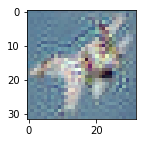

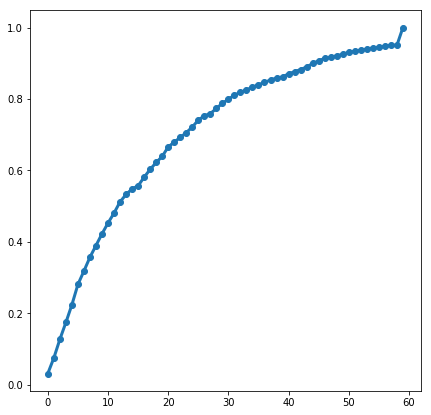

In [8]:
mean_channel = [0.4914, 0.4822, 0.4465]
std_channel = [0.2023, 0.1994, 0.2010]
def restore_fig(img):
    img = copy.deepcopy(img)
    for i in range(3):
        img[i, :, :] = 255 * (img[i, :, :] * std_channel[i] + mean_channel[i] + 1e-5)
    img = np.clip(img, 0, 255)
    
    img = img.astype(np.uint8)
    img = np.swapaxes(img, 0, 1)
    img = np.swapaxes(img, 1, 2)
    return img

def plot_img(img):
    #mport pdb
    #pdb.set_trace()
    plt.figure(figsize=(2, 2))
    plt.imshow(img)

import random
eps = [5e-4]
power = 1.05
powers = [1]
while eps[-1] <= 0.5:
    eps.append(eps[-1] * power)
    powers.append(powers[-1]*power)

def gen_grad(net, inputs, targets):
    #pdb.set_trace()
    net.zero_grad()
    inputs = torch.autograd.Variable(inputs, requires_grad=True)
    criterion = nn.CrossEntropyLoss()
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    pert = inputs.grad.data
    return pert / torch.norm(pert.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)
    
    

def experiment_attack(net_set):
    for i in range(5):
        net_set[i].eval()
    
    for i in range(2):
        for j in range(i + 1, 2):
            ratio = []
            for batch_idx, (inputs, targets) in enumerate(testloader):
                inputs = inputs.to(device)
                targets = targets.to(device)
                #pdb.set_trace()
                pert = gen_grad(net_set[i], inputs, gen_dif(targets))
                
                if batch_idx == 0:
                    inps = copy.deepcopy((inputs - pert * 0.3 * 32 * 1.7)[10].to("cpu").numpy())
                    #pdb.set_trace()
                    plot_img(restore_fig(inps))
                
                result1 = []
                result2 = []
                for eps_i in range(len(eps)):
                    inps = inputs - pert * eps[eps_i] * 32. * 1.7
                    tmp = inps.to("cpu").numpy()

                    oup1 = net_set[i](inps)
                    oup2 = net_set[j](inps)
                    _, pred1 = oup1.max(1)
                    _, pred2 = oup2.max(1)
                    res1 = copy.deepcopy(pred1.eq(targets).to("cpu").numpy())
                    res2 = copy.deepcopy(pred2.eq(targets).to("cpu").numpy())
                    result1.append(res1)
                    result2.append(res2)
                
                result1 = np.array(result1)
                result2 = np.array(result2)
                for sample in range(targets.shape[0]):
                    first_i = 0
                    first_j = 0
                    for eps_i in range(len(eps)):
                        if result1[eps_i][sample] == 0 and not first_i:
                            first_i = eps_i + 1
                        if result2[eps_i][sample] == 0 and not first_j:
                            first_j = eps_i + 1
                    if not first_i:
                        first_i = len(eps)
                    if not first_j:
                        first_j = len(eps)
                    if first_i > first_j:
                        first_i, first_j = first_j, first_i
                    
                    if first_i > 1 and first_j < len(eps):
                        ratio.append([eps[first_j - 1] / eps[first_i - 1], first_i, first_j])
                print(batch_idx)
                if batch_idx >= 8:
                    break
            #pdb.set_trace()

            print(ratio)
            return ratio
        
ratio = experiment_attack(net_set)
bins = np.zeros(60)
for item in ratio:
    bins[min(59, item[2] - item[1])] += 1
for i in range(1, 60):
    bins[i] += bins[i - 1]
bins /= bins[-1]
    
index = np.array(powers[0:60])
plt.figure(figsize=(7,7))
plt.plot(np.arange(60), bins, marker='o', linewidth=3)

In [8]:
%reload_ext autoreload
%autoreload 2
from pert_universal import pert_universal
mean_channel = [0.4914, 0.4822, 0.4465]
std_channel = [0.2023, 0.1994, 0.2010]
def restore_fig(img):
    img = copy.deepcopy(img)
    for i in range(3):
        img[i, :, :] = 255 * (img[i, :, :] * std_channel[i] + mean_channel[i] + 1e-5)
    img = np.clip(img, 0, 255)
    
    img = img.astype(np.uint8)
    img = np.swapaxes(img, 0, 1)
    img = np.swapaxes(img, 1, 2)
    return img

def plot_img(img):
    #mport pdb
    #pdb.set_trace()
    plt.figure(figsize=(2, 2))
    plt.imshow(img)

def pertube(net, inps, targets, eps):
    length = 32. * 1.7
    iter_time = 5
    pert = torch.zeros(inps.shape, dtype=torch.float32).to(device)
    
    criterion = nn.CrossEntropyLoss()

    for i in range(iter_time):
        net.zero_grad()
        inputs = torch.autograd.Variable(inps - pert, requires_grad=True)
        outputs = net(inputs)
        #import pdb
        #pdb.set_trace()
        loss = criterion(outputs, targets)
        loss.backward()
        grad = inputs.grad.data
        grad = eps * length / 3 * grad / torch.norm(grad.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)
        pert = pert + grad
        pert = eps * length * pert / torch.norm(pert.reshape(targets.shape[0], -1), dim=1).reshape(targets.shape[0], 1, 1, 1)
        pert = torch.clamp(pert, min=-1, max=1)
        
    return pert

    
def experiment_attack(net_set):
    for i in range(5):
        net_set[i].eval()
    for eps in [2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1, 3e-1]:
        for i in range(2):
            for j in range(i + 1, 2):
                pert = pert_universal(testloader, device, net_set[i], epochs=1, delta=1, xi=eps * 32 * 1.7, p=2)
                
                acc1 = 0
                acc2 = 0
                acc3 = 0
                for batch_idx, (inputs, targets) in enumerate(testloader):
                    inps = inputs.to(device)
                    tgts = targets.to(device)
                    inps += pert
                    tmp = inps.to("cpu").numpy()
                    #import pdb
                    #pdb.set_trace()
                    if batch_idx == 0:
                        plot_img(restore_fig(inputs[10].numpy()))
                        plot_img(restore_fig(tmp[10]))

                    oup1 = net_set[i](inps)
                    oup2 = net_set[j](inps)
                    _, pred1 = oup1.max(1)
                    _, pred2 = oup2.max(1)
                    acc1 += pred1.eq(tgts).sum().item()
                    acc2 += pred2.eq(tgts).sum().item()
                    acc3 += pred2.eq(pred1).sum().item()
                
                acc1 /= 10000
                acc2 /= 10000
                acc3 /= 10000
                print(acc1, acc2, acc3)

                    
                
experiment_attack(net_set)

AttributeError: 'NoneType' object has no attribute 'zero_'